In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 829, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 829 (delta 193), reused 210 (delta 159), pack-reused 570
Receiving objects: 100% (829/829), 13.95 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (533/533), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 20.8 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/hyperparameters-tuning-better/__results__.html
/kaggle/input/hyperparameters-tuning-better/better_tuning.db
/kaggle/input/hyperparameters-tuning-better/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning-better/__output__.json
/kaggle/input/hyperparameters-tuning-better/best_params_knn_user.json
/kaggle/input/hyperparameters-tuning-better/custom.css
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/rp3-tuning.ipynb
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_202

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2153


In [8]:
config = {
    'tune_parameters_item_knn': False,
    'tune_parameters_user_knn': True,
    'tune_parameters_ials': False,
    'database_path': '/kaggle/working/better_tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/better_tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


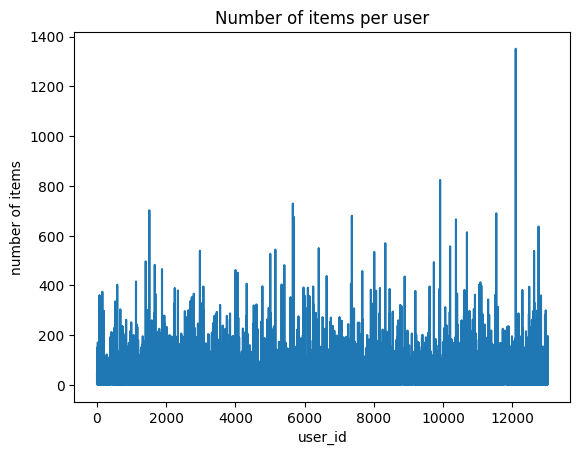

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

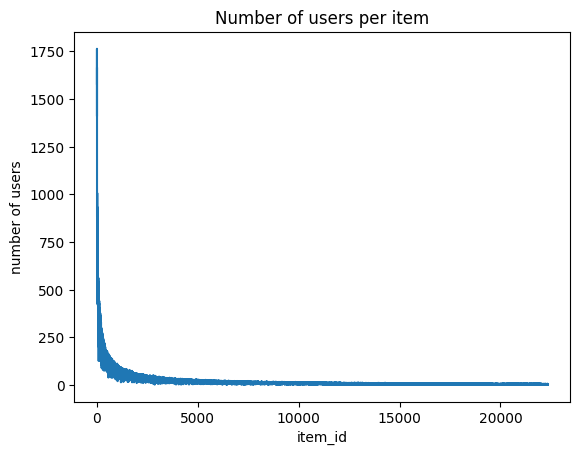

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

# Hyperparameters tuning

In [24]:
import sqlite3

def print_all_rows(table_name, database_path):
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()

    try:
        cursor.execute(f"SELECT * FROM {table_name};")
        rows = cursor.fetchall()

        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        cursor.close()
        connection.close()

print_all_rows('studies', config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_EASE_R')
(2, 'hyperparameters_tuning_knn_user_fixed')


## Item KNN Collaborative Filtering

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

In [25]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, params):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [26]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=50)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.5 µs


In [27]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [28]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [29]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [30]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [31]:
def evaluate_user_knn(URM_train, URM_valid, params):
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']

def objective_user_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_user_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
    return np.mean(results)

In [32]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user_fixed',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=125)

[I 2023-11-27 00:15:43,585] Using an existing study with name 'hyperparameters_tuning_knn_user_fixed' instead of creating a new one.


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 568 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:18:04,671] Trial 75 finished with value: 0.014582928887405417 and parameters: {'topK': 651, 'shrink': 6, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.19555693888030085}. Best is trial 73 with value: 0.014658438524848435.


MAP is 0.020200672233739645
MAP is 0.01982154775146985
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 943 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1138 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1455 (11.

[I 2023-11-27 00:20:25,998] Trial 76 finished with value: 0.014492781021597326 and parameters: {'topK': 654, 'shrink': 12, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.19555930568637858}. Best is trial 73 with value: 0.014658438524848435.


UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 777 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 512 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1458 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:22:47,036] Trial 77 finished with value: 0.013551277291360858 and parameters: {'topK': 649, 'shrink': 389, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.20583399266847516}. Best is trial 73 with value: 0.014658438524848435.


MAP is 0.018143865289101762
UserKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1463 (11.2%) users with no interacti

[I 2023-11-27 00:25:06,566] Trial 78 finished with value: 0.014392762921072642 and parameters: {'topK': 706, 'shrink': 12, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.19753657353702372}. Best is trial 73 with value: 0.014658438524848435.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 222 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 508 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1460 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:27:24,025] Trial 79 finished with value: 0.014403668890848011 and parameters: {'topK': 732, 'shrink': 11, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2545996323772678}. Best is trial 73 with value: 0.014658438524848435.


UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 220 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:29:45,267] Trial 80 finished with value: 0.013737479266459149 and parameters: {'topK': 752, 'shrink': 40, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.24488331032959237}. Best is trial 73 with value: 0.014658438524848435.


MAP is 0.018402623525346728
MAP is 0.018349250416435238
MAP is 0.01608651296463893
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 866 ( 3.9%) items with no interactions.
UserKNNCFRecomme

[I 2023-11-27 00:32:05,453] Trial 81 finished with value: 0.014702373067887794 and parameters: {'topK': 709, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.24936852480238786}. Best is trial 81 with value: 0.014702373067887794.


UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:34:23,823] Trial 82 finished with value: 0.014610974502956153 and parameters: {'topK': 697, 'shrink': 3, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2343804387049341}. Best is trial 81 with value: 0.014702373067887794.


MAP is 0.01947933771209622
MAP is 0.020535419733990964
MAP is 0.019938872096722793
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 565 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 869 ( 3.9%) items with no interactions.
UserKNNCFRecomme

[I 2023-11-27 00:36:42,766] Trial 83 finished with value: 0.014543530391140879 and parameters: {'topK': 827, 'shrink': 1, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2594295841430727}. Best is trial 81 with value: 0.014702373067887794.


UserKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 383 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1473 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:39:01,762] Trial 84 finished with value: 0.014655425654399626 and parameters: {'topK': 888, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2565635065796479}. Best is trial 81 with value: 0.014702373067887794.


MAP is 0.020076757520886925
MAP is 0.0199761055141256
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 861 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1449 (11.1

[I 2023-11-27 00:41:24,049] Trial 85 finished with value: 0.014596937121603194 and parameters: {'topK': 881, 'shrink': 1, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.32008044533944563}. Best is trial 81 with value: 0.014702373067887794.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:43:48,054] Trial 86 finished with value: 0.01351404479819274 and parameters: {'topK': 875, 'shrink': 33, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.36634341606227394}. Best is trial 81 with value: 0.014702373067887794.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 725 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 379 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1097 ( 8.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:46:08,182] Trial 87 finished with value: 0.013567509362289754 and parameters: {'topK': 849, 'shrink': 29, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.32677083694589415}. Best is trial 81 with value: 0.014702373067887794.


MAP is 0.018251385732473674
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 569 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1116 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1454 (11.2%) users with no interacti

[I 2023-11-27 00:48:28,734] Trial 88 finished with value: 0.013678954925562417 and parameters: {'topK': 795, 'shrink': 45, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.15861290439501285}. Best is trial 81 with value: 0.014702373067887794.


MAP is 0.01797963903078472
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1399 (10.7%) users with no interactio

[I 2023-11-27 00:50:47,128] Trial 89 finished with value: 0.013733710767344337 and parameters: {'topK': 691, 'shrink': 57, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3247606720606012}. Best is trial 81 with value: 0.014702373067887794.


MAP is 0.018240462112413255
UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 266 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1100 ( 8.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1370 (10.5%) users with no interacti

[I 2023-11-27 00:53:07,073] Trial 90 finished with value: 0.014220794803268686 and parameters: {'topK': 914, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.12283849398924973}. Best is trial 81 with value: 0.014702373067887794.


MAP is 0.019469710975534592
MAP is 0.019004168170463246
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 918 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11

[I 2023-11-27 00:55:21,745] Trial 91 finished with value: 0.014180239525251664 and parameters: {'topK': 942, 'shrink': 7, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.20371650850425657}. Best is trial 81 with value: 0.014702373067887794.


UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 00:57:36,982] Trial 92 finished with value: 0.014300778573472136 and parameters: {'topK': 582, 'shrink': 3, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.1512301890327718}. Best is trial 81 with value: 0.014702373067887794.


MAP is 0.019448259820541484
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 366 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1444 (11.1%) users with no interacti

[I 2023-11-27 00:59:51,143] Trial 93 finished with value: 0.014753185667643328 and parameters: {'topK': 630, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2778932188822455}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.02021307722055229
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactio

[I 2023-11-27 01:02:06,577] Trial 94 finished with value: 0.014009477138438888 and parameters: {'topK': 771, 'shrink': 27, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.06902480722132526}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1141 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1470 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 01:04:21,440] Trial 95 finished with value: 0.014002973568428936 and parameters: {'topK': 867, 'shrink': 14, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3053007096232483}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.014634765587146464
MAP is 0.013687017338972606
MAP is 0.01712247867430757
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 573 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecomme

[I 2023-11-27 01:06:38,799] Trial 96 finished with value: 0.01354099326432713 and parameters: {'topK': 828, 'shrink': 43, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.09983888094579321}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 256 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 885 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1086 ( 8.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1422 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 01:08:56,102] Trial 97 finished with value: 0.01398791508465336 and parameters: {'topK': 688, 'shrink': 25, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4423144818762522}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018897657343580714
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 364 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 862 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1438 (11.0%) users with no interacti

[I 2023-11-27 01:11:12,527] Trial 98 finished with value: 0.014079736909103923 and parameters: {'topK': 617, 'shrink': 12, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.04187276986746338}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 847 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 01:13:24,520] Trial 99 finished with value: 0.013925143050517227 and parameters: {'topK': 539, 'shrink': 77, 'similarity': 'tanimoto'}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018968034412318983
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 893 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1128 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1441 (11.1%) users with no interacti

[I 2023-11-27 01:15:41,758] Trial 100 finished with value: 0.013919497602768834 and parameters: {'topK': 757, 'shrink': 32, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2887882897441077}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018475654344425087
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 747 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 507 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10.9%) users with no interacti

[I 2023-11-27 01:17:55,204] Trial 101 finished with value: 0.0145347096483768 and parameters: {'topK': 645, 'shrink': 1, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.20812589251704283}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.019326441796014674
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 908 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1436 (11.0%) users with no interacti

[I 2023-11-27 01:20:11,371] Trial 102 finished with value: 0.014199239199323449 and parameters: {'topK': 627, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.14464548011503228}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 01:22:27,675] Trial 103 finished with value: 0.013176143413874897 and parameters: {'topK': 907, 'shrink': 187, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2905011729346276}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.017240217844070364
MAP is 0.01708271226493761
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10.

[I 2023-11-27 01:24:41,656] Trial 104 finished with value: 0.013949981164065175 and parameters: {'topK': 599, 'shrink': 20, 'similarity': 'tversky', 'tversky_alpha': 1.0128752296287926, 'tversky_beta': 1.0097382820738625}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018190680006044145
MAP is 0.018505453117907505
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 889 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11

[I 2023-11-27 01:26:57,666] Trial 105 finished with value: 0.013917284374984896 and parameters: {'topK': 665, 'shrink': 48, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.09517662005262334}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 712 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 887 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1108 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1379 (10.6%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 01:29:10,414] Trial 106 finished with value: 0.013808273514728403 and parameters: {'topK': 567, 'shrink': 67, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.48378545794423056}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.01823211225081155
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 732 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactio

[I 2023-11-27 01:31:24,107] Trial 107 finished with value: 0.013736507846830504 and parameters: {'topK': 698, 'shrink': 12, 'similarity': 'dice'}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.017959654615585255
UserKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1148 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1440 (11.1%) users with no interacti

[I 2023-11-27 01:33:40,289] Trial 108 finished with value: 0.013545945316798072 and parameters: {'topK': 944, 'shrink': 28, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2496556644452252}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018686746216050577
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1434 (11.0%) users with no interacti

[I 2023-11-27 01:35:57,956] Trial 109 finished with value: 0.013892950550041472 and parameters: {'topK': 804, 'shrink': 20, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3600065063307132}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.01841005115107501
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 525 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 845 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1456 (11.2%) users with no interactio

[I 2023-11-27 01:38:17,531] Trial 110 finished with value: 0.013871966731646096 and parameters: {'topK': 740, 'shrink': 37, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.15009644234628752}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018456977674825275MAP is 0.018227257580806334

UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1475 (11

[I 2023-11-27 01:40:32,292] Trial 111 finished with value: 0.013444744336415381 and parameters: {'topK': 649, 'shrink': 1, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.0022736883736120816}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 913 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 2.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1122 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 833 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 01:42:45,388] Trial 112 finished with value: 0.014698535974444676 and parameters: {'topK': 642, 'shrink': 5, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.22571504417771018}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1425 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 01:45:00,032] Trial 113 finished with value: 0.014651397633588525 and parameters: {'topK': 516, 'shrink': 11, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.260641485288833}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.019822531475699054
UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 389 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1195 ( 9.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1443 (11.1%) users with no interacti

[I 2023-11-27 01:47:27,093] Trial 114 finished with value: 0.014546039237748304 and parameters: {'topK': 516, 'shrink': 12, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.38065736574587683}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.017598376787408557
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 550 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 889 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1456 (11.2%) users with no interacti

[I 2023-11-27 01:53:31,901] Trial 115 finished with value: 0.0010470029237537113 and parameters: {'topK': 527, 'shrink': 15, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'exp', 'normalize': False}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.0006615770358964041
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 837 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1%) users with no interact

[I 2023-11-27 01:55:58,077] Trial 116 finished with value: 0.014248190079105702 and parameters: {'topK': 466, 'shrink': 25, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.39139351914308185}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.019395014156918893
UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 343 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1461 (11.2%) users with no interacti

[I 2023-11-27 01:58:21,010] Trial 117 finished with value: 0.01386051520452702 and parameters: {'topK': 557, 'shrink': 51, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.48191769245530014}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1429 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:00:50,970] Trial 118 finished with value: 0.014107318016753034 and parameters: {'topK': 508, 'shrink': 39, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.329322218237093}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 943 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:03:15,302] Trial 119 finished with value: 0.01393106520366241 and parameters: {'topK': 586, 'shrink': 20, 'similarity': 'tanimoto'}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.01826118486523106
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 380 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1430 (11.0%) users with no interactio

[I 2023-11-27 02:05:45,663] Trial 120 finished with value: 0.013573722652259363 and parameters: {'topK': 673, 'shrink': 13, 'similarity': 'tversky', 'tversky_alpha': 0.08902518093693934, 'tversky_beta': 0.12738277597408065}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018159416954962305
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1421 (10.9%) users with no interacti

[I 2023-11-27 02:08:09,913] Trial 121 finished with value: 0.014630807717716035 and parameters: {'topK': 608, 'shrink': 10, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.26331320167921546}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1183 ( 9.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 871 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1471 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:10:30,542] Trial 122 finished with value: 0.014504263581225248 and parameters: {'topK': 611, 'shrink': 10, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.24730704196764}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1421 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:12:52,405] Trial 123 finished with value: 0.014033686485681502 and parameters: {'topK': 631, 'shrink': 35, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.18905676793991916}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1163 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 900 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:15:14,176] Trial 124 finished with value: 0.01404575307836968 and parameters: {'topK': 679, 'shrink': 25, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.37835430939408365}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018802112472861687
UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 586 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 513 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1410 (10.8%) users with no interacti

[I 2023-11-27 02:17:34,723] Trial 125 finished with value: 0.014387453150726426 and parameters: {'topK': 719, 'shrink': 8, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.27362271030013685}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.01971817836571935
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 719 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 863 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1391 (10.7%) users with no interactio

[I 2023-11-27 02:19:55,167] Trial 126 finished with value: 0.01394793886797771 and parameters: {'topK': 507, 'shrink': 59, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.20637052009433296}. Best is trial 93 with value: 0.014753185667643328.



UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 529 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1165 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1450 (11.1%) users with no interactions.
UserKNNCFRecommender: 

[I 2023-11-27 02:22:17,243] Trial 127 finished with value: 0.013792572215848176 and parameters: {'topK': 990, 'shrink': 11, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3073565544465412}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018865653862328236
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 187 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1145 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 905 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1%) users with no interacti

[I 2023-11-27 02:24:34,633] Trial 128 finished with value: 0.013892064607793853 and parameters: {'topK': 485, 'shrink': 43, 'similarity': 'dice'}. Best is trial 93 with value: 0.014753185667643328.


MAP is 0.018434952809952772
MAP is 0.0186198410931209
UserKNNCFRecommender: URM Detected 501 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1438 (11.0

[I 2023-11-27 02:26:55,792] Trial 129 finished with value: 0.013671937117467208 and parameters: {'topK': 604, 'shrink': 250, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.10153529520074803}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 928 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 519 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1135 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:29:16,182] Trial 130 finished with value: 0.014368249951352918 and parameters: {'topK': 442, 'shrink': 28, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2599834718668688}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1171 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 908 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:31:38,935] Trial 131 finished with value: 0.014719901956028727 and parameters: {'topK': 711, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.24186075858739528}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 250 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 891 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1427 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:33:57,770] Trial 132 finished with value: 0.014185291362915024 and parameters: {'topK': 710, 'shrink': 19, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.19105316528345692}. Best is trial 93 with value: 0.014753185667643328.


UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 751 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1449 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:36:19,473] Trial 133 finished with value: 0.014950723201489694 and parameters: {'topK': 634, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.39534715945668714}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1407 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:38:53,811] Trial 134 finished with value: 0.014348299341838419 and parameters: {'topK': 640, 'shrink': 6, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.16241756603410262}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.019672829892519304
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1453 (11.2%) users with no interacti

[I 2023-11-27 02:41:34,601] Trial 135 finished with value: 0.014530596422762351 and parameters: {'topK': 693, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.24088708355112048}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.018067261203036974
MAP is 0.0195735174045917
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 746 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 882 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1428 (11.0

[I 2023-11-27 02:44:12,750] Trial 136 finished with value: 0.014030297444827805 and parameters: {'topK': 669, 'shrink': 27, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3234131223109572}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.01786012430126506
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 369 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 577 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1418 (10.9%) users with no interactio

[I 2023-11-27 02:46:41,659] Trial 137 finished with value: 0.013782966495627703 and parameters: {'topK': 574, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.13227061304662746}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.015135843281297728
MAP is 0.018402352623567694
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10

[I 2023-11-27 02:53:46,826] Trial 138 finished with value: 0.010126106352755047 and parameters: {'topK': 625, 'shrink': 35, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'log', 'normalize': True}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 779 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 562 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1175 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1462 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 02:56:10,418] Trial 139 finished with value: 0.014038995394964438 and parameters: {'topK': 776, 'shrink': 19, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.24011729242053087}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.017064025513919927
MAP is 0.018945030112511738
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 924 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1121 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 854 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1413 (10

[I 2023-11-27 02:58:32,069] Trial 140 finished with value: 0.014556340741646167 and parameters: {'topK': 591, 'shrink': 11, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3301166812700709}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.019680734937589848
UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 631 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 735 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1459 (11.2%) users with no interacti

[I 2023-11-27 03:00:52,013] Trial 141 finished with value: 0.014632681412121581 and parameters: {'topK': 588, 'shrink': 11, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.32143619112063865}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1419 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:03:14,537] Trial 142 finished with value: 0.01470479432317356 and parameters: {'topK': 615, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2858943597044685}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.020228657085752354
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 960 ( 7.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 553 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 821 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1438 (11.0%) users with no interacti

[I 2023-11-27 03:05:36,222] Trial 143 finished with value: 0.014770924706904016 and parameters: {'topK': 553, 'shrink': 8, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2708974799125455}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.01943823391222325
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 620 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1169 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactio

[I 2023-11-27 03:07:54,102] Trial 144 finished with value: 0.014767235204391624 and parameters: {'topK': 542, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.43050214055422}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 248 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 345 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:10:14,470] Trial 145 finished with value: 0.014171194316623701 and parameters: {'topK': 569, 'shrink': 21, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.42265416101961095}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 769 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 940 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:12:35,457] Trial 146 finished with value: 0.014345780470361552 and parameters: {'topK': 550, 'shrink': 30, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2951031694973548}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 890 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 574 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 857 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1423 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:14:59,669] Trial 147 finished with value: 0.013619557218816743 and parameters: {'topK': 610, 'shrink': 147, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.36062602794484744}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1109 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1420 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:17:27,239] Trial 148 finished with value: 0.014035995695411469 and parameters: {'topK': 536, 'shrink': 10, 'similarity': 'tanimoto'}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.0186943208503275
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1473 (11.3%) users with no interaction

[I 2023-11-27 03:19:59,387] Trial 149 finished with value: 0.014534112246720427 and parameters: {'topK': 596, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.24735966335741885}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.02002321836646452
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1119 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactio

[I 2023-11-27 03:22:30,819] Trial 150 finished with value: 0.013704917858343126 and parameters: {'topK': 625, 'shrink': 45, 'similarity': 'tversky', 'tversky_alpha': 1.958773491058256, 'tversky_beta': 1.9794480260834573}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.017951343310858375
UserKNNCFRecommender: URM Detected 462 ( 3.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 579 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 901 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 878 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1423 (10.9%) users with no interacti

[I 2023-11-27 03:24:58,374] Trial 151 finished with value: 0.014319552788259065 and parameters: {'topK': 663, 'shrink': 18, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2917887985763882}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 225 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1414 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:27:21,553] Trial 152 finished with value: 0.014408378836797978 and parameters: {'topK': 553, 'shrink': 9, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.2030517914321106}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.019600545169291664
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 829 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1469 (11.3%) users with no interacti

[I 2023-11-27 03:29:52,333] Trial 153 finished with value: 0.014819171397678346 and parameters: {'topK': 634, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3508842449022187}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1134 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:32:15,744] Trial 154 finished with value: 0.014165142296581107 and parameters: {'topK': 627, 'shrink': 22, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.40836469949559606}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.018842766600338925
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 540 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 877 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1480 (11.4%) users with no interacti

[I 2023-11-27 03:34:37,286] Trial 155 finished with value: 0.01457370944739889 and parameters: {'topK': 585, 'shrink': 9, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3466215791141993}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1429 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:37:02,441] Trial 156 finished with value: 0.013906214380352725 and parameters: {'topK': 684, 'shrink': 32, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.28121737085031356}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.018427178828993907
UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 783 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 942 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1185 ( 9.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1450 (11.1%) users with no interacti

[I 2023-11-27 03:39:20,977] Trial 157 finished with value: 0.014166964937485408 and parameters: {'topK': 644, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.15302947571314576}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 638 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 840 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1457 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:41:39,678] Trial 158 finished with value: 0.01432666179113647 and parameters: {'topK': 610, 'shrink': 18, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.22367225124497095}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 626 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 941 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 522 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 918 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1444 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:44:03,048] Trial 159 finished with value: 0.01353609380394557 and parameters: {'topK': 709, 'shrink': 378, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.0638427616211916}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 335 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 03:46:32,284] Trial 160 finished with value: 0.014806983442304933 and parameters: {'topK': 569, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4543755737774328}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.020382134302613847
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 374 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1483 (11.4%) users with no interacti

[I 2023-11-27 03:48:54,977] Trial 161 finished with value: 0.014464136701872554 and parameters: {'topK': 568, 'shrink': 11, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.44984443656743633}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.019191028425575008
UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 771 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 526 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1146 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1451 (11.1%) users with no interacti

[I 2023-11-27 03:51:12,940] Trial 162 finished with value: 0.014251084734234674 and parameters: {'topK': 548, 'shrink': 22, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.38193108837124556}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.017557525773559988
MAP is 0.01866647386983915
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 760 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 948 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 592 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1471 (11.

[I 2023-11-27 03:53:22,273] Trial 163 finished with value: 0.014188266186627784 and parameters: {'topK': 523, 'shrink': 0, 'similarity': 'dice'}. Best is trial 133 with value: 0.014950723201489694.



UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1132 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactions.
UserKNNCFRecommender: 

[I 2023-11-27 03:55:34,320] Trial 164 finished with value: 0.01450849335593501 and parameters: {'topK': 658, 'shrink': 11, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.28547692125410923}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.019451476960055603
UserKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 784 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 329 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1487 (11.4%) users with no interacti

[I 2023-11-27 03:57:47,437] Trial 165 finished with value: 0.014856703219957962 and parameters: {'topK': 590, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5072615522216393}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.02030002411670368
MAP is 0.02029589495803468
UserKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 726 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 371 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 932 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0

[I 2023-11-27 03:59:57,199] Trial 166 finished with value: 0.013997298087124571 and parameters: {'topK': 584, 'shrink': 28, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5225910295674133}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1110 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 897 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1417 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:02:11,407] Trial 167 finished with value: 0.014292993978100414 and parameters: {'topK': 602, 'shrink': 16, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.35804555143909356}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 590 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 894 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1447 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:04:24,241] Trial 168 finished with value: 0.014786212525859455 and parameters: {'topK': 633, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3910176508695584}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.019403208243698997
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 717 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1414 (10.9%) users with no interacti

[I 2023-11-27 04:06:40,860] Trial 169 finished with value: 0.013977936218000786 and parameters: {'topK': 633, 'shrink': 39, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.420496173254642}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:08:55,792] Trial 170 finished with value: 0.014941933155702216 and parameters: {'topK': 568, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4772376309638873}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.019758697560949907
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 945 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 872 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1%) users with no interacti

[I 2023-11-27 04:11:06,948] Trial 171 finished with value: 0.014737036025712275 and parameters: {'topK': 564, 'shrink': 1, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5352078656910699}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 637 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 754 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:13:23,114] Trial 172 finished with value: 0.014592115328675086 and parameters: {'topK': 561, 'shrink': 2, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5547423115576149}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:15:35,008] Trial 173 finished with value: 0.014904862921518441 and parameters: {'topK': 531, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.46518771825615135}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 511 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1452 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:17:46,509] Trial 174 finished with value: 0.014192920196524659 and parameters: {'topK': 535, 'shrink': 21, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.46988036212563145}. Best is trial 133 with value: 0.014950723201489694.


UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 716 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 373 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 598 ( 2.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 898 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1398 (10.7%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:23:15,369] Trial 175 finished with value: 0.00121626103326553 and parameters: {'topK': 493, 'shrink': 0, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'exp', 'normalize': False}. Best is trial 133 with value: 0.014950723201489694.


MAP is 0.0013976466255441386
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 557 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1420 (10.9%) users with no interact

[I 2023-11-27 04:25:31,088] Trial 176 finished with value: 0.014953335309237065 and parameters: {'topK': 507, 'shrink': 1, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5090830821219586}. Best is trial 176 with value: 0.014953335309237065.


UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1158 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 886 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1428 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:27:43,695] Trial 177 finished with value: 0.01487360746535003 and parameters: {'topK': 534, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5113057966423886}. Best is trial 176 with value: 0.014953335309237065.


MAP is 0.020076451111952318
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 930 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1140 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 828 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1460 (11.2%) users with no interacti

[I 2023-11-27 04:29:53,705] Trial 178 finished with value: 0.014858961926048363 and parameters: {'topK': 496, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.49234527658445837}. Best is trial 176 with value: 0.014953335309237065.


UserKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 625 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 335 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 522 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1452 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:32:01,931] Trial 179 finished with value: 0.013671099939687145 and parameters: {'topK': 492, 'shrink': 458, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5124337347395009}. Best is trial 176 with value: 0.014953335309237065.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 265 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 372 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 951 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1159 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:34:16,060] Trial 180 finished with value: 0.014709329393898515 and parameters: {'topK': 535, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5698242662668436}. Best is trial 176 with value: 0.014953335309237065.


MAP is 0.017724384808686156
MAP is 0.019933511832147716
MAP is 0.019554444182944972
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 598 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 890 ( 4.0%) items with no interactions.
UserKNNCFRecomm

[I 2023-11-27 04:36:29,866] Trial 181 finished with value: 0.014154373896700073 and parameters: {'topK': 532, 'shrink': 16, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5800221631190008}. Best is trial 176 with value: 0.014953335309237065.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 763 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 334 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 898 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1169 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 829 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1404 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:38:44,576] Trial 182 finished with value: 0.014928807153670644 and parameters: {'topK': 550, 'shrink': 1, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4532906910850645}. Best is trial 176 with value: 0.014953335309237065.


MAP is 0.0179122662963314
MAP is 0.02072117338733904
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1145 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1479 (11.4%

[I 2023-11-27 04:40:54,906] Trial 183 finished with value: 0.014988823391279073 and parameters: {'topK': 458, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4473115206842523}. Best is trial 183 with value: 0.014988823391279073.


MAP is 0.020092117826414856
UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 585 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 259 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 874 ( 6.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 891 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1400 (10.7%) users with no interacti

[I 2023-11-27 04:43:06,463] Trial 184 finished with value: 0.01441190887820494 and parameters: {'topK': 457, 'shrink': 24, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4667035869158551}. Best is trial 183 with value: 0.014988823391279073.


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 775 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 381 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 898 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1433 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:45:19,827] Trial 185 finished with value: 0.014345629307859306 and parameters: {'topK': 547, 'shrink': 10, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.506899707501553}. Best is trial 183 with value: 0.014988823391279073.


UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 751 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 868 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1475 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:47:28,809] Trial 186 finished with value: 0.01378776902309559 and parameters: {'topK': 507, 'shrink': 314, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.555128164205715}. Best is trial 183 with value: 0.014988823391279073.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 760 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 557 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 907 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1477 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:49:38,627] Trial 187 finished with value: 0.014022300357984485 and parameters: {'topK': 473, 'shrink': 0, 'similarity': 'jaccard'}. Best is trial 183 with value: 0.014988823391279073.


MAP is 0.018782835750463956
MAP is 0.018137246335366838
UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 781 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 957 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 841 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1473 (11

[I 2023-11-27 04:51:50,715] Trial 188 finished with value: 0.014190334817028628 and parameters: {'topK': 429, 'shrink': 17, 'similarity': 'tanimoto'}. Best is trial 183 with value: 0.014988823391279073.


UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 778 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 572 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:54:04,918] Trial 189 finished with value: 0.015024191134272946 and parameters: {'topK': 526, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4378094229536198}. Best is trial 189 with value: 0.015024191134272946.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 775 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 971 ( 7.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 578 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1190 ( 9.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1502 (11.5%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:56:17,697] Trial 190 finished with value: 0.01414923904761572 and parameters: {'topK': 519, 'shrink': 28, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.44190574500760466}. Best is trial 189 with value: 0.015024191134272946.


UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 957 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1458 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 04:58:30,167] Trial 191 finished with value: 0.014957738706021361 and parameters: {'topK': 554, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.40872596173614795}. Best is trial 189 with value: 0.015024191134272946.


MAP is 0.0207932576785537
MAP is 0.017852629078238775
UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 770 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 924 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 511 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1176 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 829 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1444 (11.1

[I 2023-11-27 05:00:46,064] Trial 192 finished with value: 0.014573414123456585 and parameters: {'topK': 565, 'shrink': 9, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.43406855017711243}. Best is trial 189 with value: 0.015024191134272946.


MAP is 0.02004933588174516
UserKNNCFRecommender: URM Detected 466 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 720 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 553 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1449 (11.1%) users with no interactio

[I 2023-11-27 05:02:57,892] Trial 193 finished with value: 0.014860988491653484 and parameters: {'topK': 539, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4973092216410648}. Best is trial 189 with value: 0.015024191134272946.


UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 937 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 880 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 05:05:12,969] Trial 194 finished with value: 0.014408444574818439 and parameters: {'topK': 551, 'shrink': 14, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4145535015435934}. Best is trial 189 with value: 0.015024191134272946.


MAP is 0.019458968887762124
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 745 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 338 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 875 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1443 (11.1%) users with no interacti

[I 2023-11-27 05:07:27,577] Trial 195 finished with value: 0.014693207657715951 and parameters: {'topK': 489, 'shrink': 10, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4739763187043486}. Best is trial 189 with value: 0.015024191134272946.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 576 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 754 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1109 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 873 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1429 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 05:09:40,507] Trial 196 finished with value: 0.014210002933447052 and parameters: {'topK': 511, 'shrink': 19, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5042968565582261}. Best is trial 189 with value: 0.015024191134272946.


UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 264 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 746 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 368 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 905 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 567 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1118 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1435 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 05:11:54,711] Trial 197 finished with value: 0.014068813985105294 and parameters: {'topK': 578, 'shrink': 9, 'similarity': 'tversky', 'tversky_alpha': 0.6478615017347478, 'tversky_beta': 0.7199364823299986}. Best is trial 189 with value: 0.015024191134272946.


MAP is 0.019007347380934816
UserKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 580 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1411 (10.8%) users with no interacti

[I 2023-11-27 05:14:09,048] Trial 198 finished with value: 0.014331697335267058 and parameters: {'topK': 533, 'shrink': 26, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4038601530256363}. Best is trial 189 with value: 0.015024191134272946.


UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-27 05:16:21,851] Trial 199 finished with value: 0.014698262661571085 and parameters: {'topK': 562, 'shrink': 8, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.466520721081181}. Best is trial 189 with value: 0.015024191134272946.


MAP is 0.020585572851717915
CPU times: user 7h 1min 41s, sys: 1h 45min 8s, total: 8h 46min 49s
Wall time: 5h 38s


In [33]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

# Alternating Least Squares

In [37]:
def objective_ials(trial):
    params = {
        'reg': trial.suggest_float('reg', 1e-7, 10, log=True),
        'alpha': trial.suggest_float('alpha', 0.01, 10),
        'num_factors': trial.suggest_int('num_factors', 5, 300),
        'confidence_scaling': trial.suggest_categorical('confidence_scaling', ['linear', 'log'])
    }
    
    if params['confidence_scaling'] == 'log':
        params['epsilon'] = trial.suggest_float('epsilon', 0.1, 10, log=True)
        
    evaluator_validation = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
    early_stopping_params = {
        'epochs_min': 1,
        'stop_on_validation': True,
        'validation_every_n': 1,
        'validation_metric': 'MAP',
        'lower_validations_allowed': 15,
        'evaluator_object': evaluator_validation
    }

    recommender = IALSRecommender(URM_train)
    recommender.fit(**params, **early_stopping_params)
    
    epochs = recommender.get_early_stopping_final_epochs_dict()["epochs"]
    trial.set_user_attr("epochs", epochs) 

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    return result_df.loc[10, 'MAP']

In [38]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials_no_cv',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=7)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.3 µs


In [39]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials_v2.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials_v2.json', 
            'tuning_results/best_params_ials_v2.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials_v2.json', 
        '/kaggle/working/best_params_ials_v2.json'
    )

In [43]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/better_tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [44]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [45]:
# user_ids_test.info()

In [46]:
# user_ids_test.head(5)

In [47]:
# user_ids_test['user_id'].unique()

In [48]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [49]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)